<h1>Содержание<span class="tocSkip"></span></h1>
<a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;<x/span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#LogisticRegression" data-toc-modified-id="LogisticRegression-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>LogisticRegression</a></span></li><li><span><a href="#DecisionTreeClassifier" data-toc-modified-id="DecisionTreeClassifier-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>DecisionTreeClassifier</a></span></li><li><span><a href="#Выбираем-лучшую-модель" data-toc-modified-id="Выбираем-лучшую-модель-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Выбираем лучшую модель</a></span></li><li><span><a href="#Лучшая-модель-на-тестовых-данных" data-toc-modified-id="Лучшая-модель-на-тестовых-данных-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Лучшая модель на тестовых данных</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from pymystem3 import Mystem

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize, pos_tag

from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    GridSearchCV
)

from sklearn.pipeline import Pipeline

from sklearn.feature_extraction.text import(
    CountVectorizer,
    TfidfVectorizer
)

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import (
    f1_score,
    accuracy_score,
    precision_score,
    recall_score,
    confusion_matrix
)

import warnings
warnings.filterwarnings('ignore')

RANDOM_STATE = 228
wordnet = WordNetLemmatizer()

nltk.download('stopwords')

stopwords = list(stopwords.words('english'))

m = Mystem()

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df_1 = 'C:/Users/Gpets/Data With Python/toxic_comments.csv'

df_2 = '/datasets/toxic_comments.csv'

def load_data(primary_path, secondary_path):
    if os.path.exists(primary_path):
        try:
            return pd.read_csv(primary_path, sep=',')
        except:
            return pd.read_csv(primary_path, sep=';')
    elif os.path.exists(secondary_path):
        try:
            return pd.read_csv(secondary_path, sep=',')
        except:
            return pd.read_csv(secondary_path, sep=';')
    else:
        print(f"Файл не найден: {primary_path} или {secondary_path}")
        return None


df = load_data(df_1, df_2)

In [3]:
df.head()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


Проверем наши данные на наличие пропусков

In [5]:
df.isnull().sum()

Unnamed: 0    0
text          0
toxic         0
dtype: int64

Классы целевого признака несбалансированы. Нужно провести поиск лучшего способа балансировки и сравнить их качество.

In [6]:
df['toxic'].value_counts(normalize = True)

0    0.898388
1    0.101612
Name: toxic, dtype: float64

Для начала очистим тексты от символов.

In [7]:
def lemmatize_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    lemmatized_words = []
    
    for token, tag in pos_tag(word_tokenize(text)):
        pos = tag[0].lower() 
        if pos not in ['a', 'r', 'n', 'v']:
            pos = 'n'
        lemmatized_words.append(wordnet.lemmatize(token, pos))
    
    return " ".join(lemmatized_words)

df['lemm_text'] = df['text'].apply(lemmatize_text)
df = df.drop(['text'], axis=1)
df = df.drop(['Unnamed: 0'], axis=1)

In [8]:
df.head()

,toxic,lemm_text
0,0,explanation why the edits make under my userna...
1,0,daww he match this background colour im seemin...
2,0,hey man im really not try to edit war it just ...
3,0,more i cant make any real suggestion on improv...
4,0,you sir be my hero any chance you remember wha...


Теперь разобьем выборку по отношению 60/20/20.

In [9]:
X = df.drop(['toxic'], axis=1)
y = df['toxic']

X_train, X_temp, y_train, y_temp = train_test_split(
    X,
    y,
    test_size=0.4,
    random_state=RANDOM_STATE)

X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp,
    y_temp,
    test_size=0.5,
    random_state=RANDOM_STATE)

Создаем матрицу cо значениями `TF-IDF` по лемметезированным текстам.

In [10]:
count_tf_idf = TfidfVectorizer(stop_words=stopwords)

X_train = count_tf_idf.fit_transform(X_train['lemm_text'])
X_valid = count_tf_idf.transform(X_valid['lemm_text'])
X_test = count_tf_idf.transform(X_test['lemm_text'])
print(X_train.shape, X_valid.shape, X_test.shape)

(95575, 148047) (31858, 148047) (31859, 148047)


## Обучение

### LogisticRegression

Попробуем модель LogisticRegression:

In [11]:
%%time
model_lr = LogisticRegression(random_state=RANDOM_STATE, class_weight='balanced', solver='liblinear')

param_grid_lr = [
    {
        'C': [1, 10],
        'penalty':['l1', 'l2']
    }
]

gs_lr = GridSearchCV(
    model_lr, 
    param_grid_lr,
    cv=3, 
    scoring='f1')

gs_lr.fit(X_train, y_train)


# Лучшие параметры
print('GridSearchCV - Лучшая модель и её параметры:\n\n', gs_lr.best_params_)
print('GridSearchCV - Метрика лучшей модели на кросс-валидации:', gs_lr.best_score_)

GridSearchCV - Лучшая модель и её параметры:

 {'C': 10, 'penalty': 'l2'}
GridSearchCV - Метрика лучшей модели на кросс-валидации: 0.7539100170985348
CPU times: user 1min 18s, sys: 44.8 s, total: 2min 3s
Wall time: 2min 3s


Проверим на валидационной:

In [12]:
%%time
best_lr = gs_lr.best_estimator_
best_lr.fit(X_train, y_train)

target_predict = best_lr.predict(X_valid)
valid_f1_LR = f1_score(y_valid, target_predict)

print('F1 на валидации', valid_f1_LR)

F1 на валидации 0.7624487404803749
CPU times: user 13.1 s, sys: 11.1 s, total: 24.2 s
Wall time: 24.2 s


### DecisionTreeClassifier

Теперь проверим DecisionTreeClassifier:

In [13]:
%%time
model_dt = DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight='balanced', )

param_grid_dt = [
    {
        'max_depth': range(2, 5),
        'max_features': range(2, 5)
    },
]


gs_dt = GridSearchCV(
    model_dt, 
    param_grid_dt,
    cv=3, 
    scoring='f1')

gs_dt.fit(X_train, y_train)


# Лучшие параметры
print('GridSearchCV - Лучшая модель и её параметры:\n\n', gs_dt.best_estimator_)
print('GridSearchCV - Метрика лучшей модели на кросс-валидации:', gs_dt.best_score_)

GridSearchCV - Лучшая модель и её параметры:

 DecisionTreeClassifier(class_weight='balanced', max_depth=3, max_features=3,
                       random_state=228)
GridSearchCV - Метрика лучшей модели на кросс-валидации: 0.18366548327325882
CPU times: user 3.19 s, sys: 194 ms, total: 3.39 s
Wall time: 3.39 s


Проверим на валидационной:

In [14]:
%%time
best_dt = gs_dt.best_estimator_
best_dt.fit(X_train, y_train)

target_predict_DTC = best_dt.predict(X_valid)
valid_f1_DTC = f1_score(y_valid, target_predict_DTC)

print('F1 на валидации', valid_f1_DTC)

F1 на валидации 0.18198981635104985
CPU times: user 119 ms, sys: 3.61 ms, total: 123 ms
Wall time: 123 ms


### Выбираем лучшую модель

Выведем таблицу валидации лучших моделей.

In [15]:
index = ['LogisticRegression',
         'DecisionTreeClassifier']
data = {'F1 на CV':[gs_lr.best_score_,
                    gs_dt.best_score_],
        'F1 на валидации':[valid_f1_LR,
                           valid_f1_DTC]}

scores_data = pd.DataFrame(data=data, index=index)
scores_data['Выполнение задачи'] = scores_data['F1 на валидации'] > 0.75
scores_data

,F1 на CV,F1 на валидации,Выполнение задачи
LogisticRegression,0.753910,0.762449,True
DecisionTreeClassifier,0.183665,0.181990,False


### Лучшая модель на тестовых данных

Проверим лучшую модель на тестовой выборке:

In [16]:
pred_test = best_lr.predict(X_test)
f1_lr = f1_score(y_test, pred_test)     
f1_lr

0.7569844166783659

Задача выполнена

## Выводы

Проведем получение F1-меры, precision, recall, accuracyюl. Так же построим матрицу ошибок

Метрики LogisticRegression
F1: 0.757
Recall: 0.805
Precision: 0.714
Accuracy: 0.946


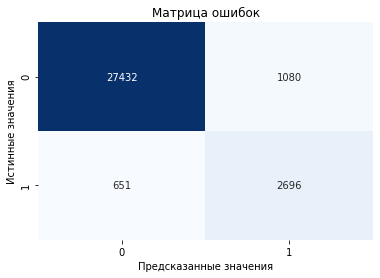

In [17]:
print('Метрики LogisticRegression')
accuracy = accuracy_score(y_test, pred_test)
recall = recall_score(y_test, pred_test)
precision = precision_score(y_test, pred_test)
print(f"F1: {f1_lr:.3f}")
print(f"Recall: {recall:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Accuracy: {accuracy:.3f}")

cm = confusion_matrix(y_test, pred_test)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Предсказанные значения')
plt.ylabel('Истинные значения')
plt.title('Матрица ошибок')
plt.show()


В ходе работы над проектом было сделано:

* **Подготовленны данные обучения на моделях.**
* **Выбран способ баланса классов и поделены данные на обучающую, валидационную и тестовою выборку.**
* **Обучены модели и выбраны лучшие из них на валидационной выборке.**

Данные обладают большим количеством признаков. Созданных столбцов больше, чем записей. Лучшей моделью стала `LogisticRegression`  с подробранными гиперпараметрами `C = 10`, `penalty = 'l2'`.

На тестовой выбоке по метрике `F1` показал 0.756. Данная модель обладает большими показателями `Precision` и `Accuracy`. Это говорит нам, что токсичные комментарии находятся хорошо.

